In [258]:
import importlib
import Blackjack_simulator as bjck
importlib.reload(bjck)


<module 'Blackjack_simulator' from 'c:\\Users\\chuck\\Desktop\\ds543\\git\\BlackJack-RL-DQN\\Blackjack_simulator.py'>

In [259]:
import Blackjack_simulator as bjck
from Blackjack_simulator import deal
from Blackjack_simulator import draw
import gymnasium as gym
from typing import Optional, Tuple, Union
from gymnasium import logger, spaces

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [260]:
class BlackJackEnv(gym.Env):
    def __init__(self):
        super(BlackJackEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Hit or Stand
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 1]), high=np.array([21, 4, 11]), dtype=np.float32)
        self.reset()  # Initialize variables properly

    def reset(self, *, seed: Optional[int] = 42, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.score, self.hand = deal()
        self.aces = sum(1 for card in self.hand if card == 11)
        self.open_card = draw()
        obs = np.array([self.score, self.aces, self.open_card], dtype=np.float32)
        return obs, {}  # info dictionary is empty



    def rewardfnc(self, score):
        if score > 21:
            return -1
        else:
            dealers_total = bjck.dealer_from_hand(self.open_card)
            if score > dealers_total:
                return 1
            elif score < dealers_total:
                return -1
            else: return 0

    def step(self, action):
        if action == 0:  # Stand
            return np.array([self.score, self.aces, self.open_card]), self.rewardfnc(self.score), True, False, {}
        
        card = draw()
        self.score += card
        if card == 11:
            self.aces += 1

        while self.score > 21 and self.aces > 0:
            self.score -= 10
            self.aces -= 1

        terminated = self.score > 21
        reward = -1 if terminated else 0
        return np.array([self.score, self.aces, self.open_card]), reward, terminated, False, {}

env = BlackJackEnv()

In [261]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [262]:

env = BlackJackEnv()
num_episodes = 10000
total_reward = 0

for _ in range(1000):
    state = env.reset()
    terminated = False
    episode_reward = 0
    
    while not terminated:
        action = env.action_space.sample()  # Choose random action (Hit or Stand)
        next_state, reward, terminated,_ , _ = env.step(action)
        episode_reward += reward
    
    total_reward += episode_reward

average_reward = total_reward / num_episodes

print(f"Average Reward over {num_episodes} episodes: {average_reward:.4f}")

Average Reward over 10000 episodes: -0.0318


In [263]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [264]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-4
seed = 5201
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(seed=seed)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []




In [265]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


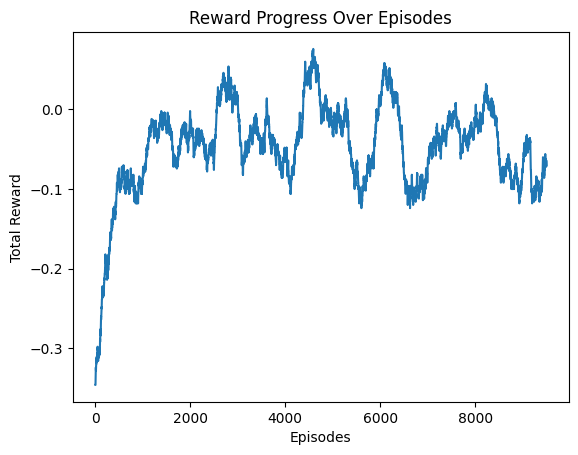

Training Complete, average reward over last 500 episodes: -0.07


In [266]:
import matplotlib.pyplot as plt
import numpy as np

def dqnmod(steps = 10000):
    reward_history = []  

    for i_episode in range(steps):
        state, info = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Optimize the model
            optimize_model()

            # Update the target network
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_reward += reward.item()
                reward_history.append(episode_reward)
                break

        # Print progress every 1000 episodes
        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return reward_history
def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
smoothed_rewards = moving_average(dqnmod(), 500)
    # Plot the total rewards over episodes
plt.plot(smoothed_rewards)
plt.title('Reward Progress Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')


In [267]:
""" def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way
    for _ in range(num_episodes):
        state, _ = env.reset(seed=20)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        print("Starting a new episode...\n")
        
        total_reward = 0
        terminated = False
        
        while not terminated:
            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()
            print(f"Agent's score: {score}, Aces: {aces}")
            print(f"Dealer's open card: {int(open_card)}")
            
            action = select_action(state)
            if action.item() == 0:
                print("Action: Stand")
            else:
                print("Action: Hit")
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            
            new_score, new_aces, new_open_card = next_state[0], next_state[1], next_state[2]
            print(f"New score: {new_score}, Aces: {new_aces}")
            print(f"Dealer's open card: {int(new_open_card)}\n")
            
            total_reward += reward
            
            if terminated:
                print(f"Episode terminated. Total reward: {total_reward}")
                break

run_agent(env, policy_net) """

' def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way\n    for _ in range(num_episodes):\n        state, _ = env.reset(seed=20)\n        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)\n        \n        print("Starting a new episode...\n")\n        \n        total_reward = 0\n        terminated = False\n        \n        while not terminated:\n            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()\n            print(f"Agent\'s score: {score}, Aces: {aces}")\n            print(f"Dealer\'s open card: {int(open_card)}")\n            \n            action = select_action(state)\n            if action.item() == 0:\n                print("Action: Stand")\n            else:\n                print("Action: Hit")\n            \n            next_state, reward, terminated, truncated, _ = env.step(action.item())\n            \n            state = torch.tensor(next_s

In [268]:
def reset_agent():
    global policy_net, target_net, optimizer, memory, steps_done

    # Reinitialize networks
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # Reset optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

    # Clear replay memory
    memory = ReplayMemory(10000)

    # Reset step counter
    steps_done = 0

    print("Agent has been reset.")

# Call reset_agent() when needed
reset_agent()


Agent has been reset.


In [269]:
class DoubleDQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DoubleDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [270]:

num_episodes = 10000
reward_history = []
def doubledqn(num_episodes=10000):
    for i_episode in range(num_episodes):
        state, _ = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()
            
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)
            
            episode_reward += reward.item()
            if terminated:
                reward_history.append(episode_reward)
                break
        
        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return reward_history

Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


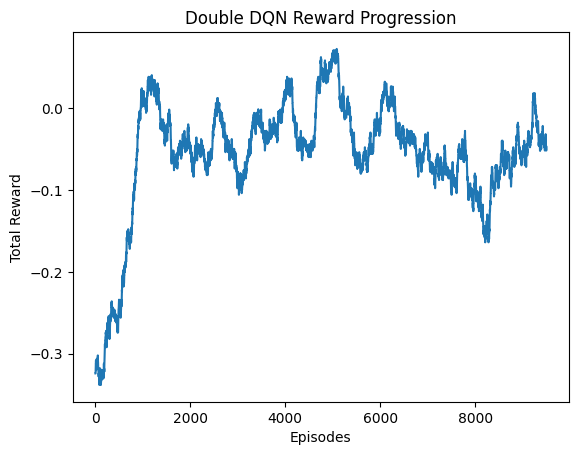

Training Complete, average reward over last 500 episodes: -0.05


In [271]:
import matplotlib.pyplot as plt
smoothed_rewards = np.convolve(doubledqn(), np.ones(500)/500, mode='valid')
plt.plot(smoothed_rewards)
plt.title('Double DQN Reward Progression')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()
print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')

In [272]:
""" def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way
    for _ in range(num_episodes):
        state, _ = env.reset(seed=20)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        print("Starting a new episode...\n")
        
        total_reward = 0
        terminated = False
        
        while not terminated:
            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()
            print(f"Agent's score: {score}, Aces: {aces}")
            print(f"Dealer's open card: {int(open_card)}")
            
            action = select_action(state)
            if action.item() == 0:
                print("Action: Stand")
            else:
                print("Action: Hit")
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            
            new_score, new_aces, new_open_card = next_state[0], next_state[1], next_state[2]
            print(f"New score: {new_score}, Aces: {new_aces}")
            print(f"Dealer's open card: {int(new_open_card)}\n")
            
            total_reward += reward
            
            if terminated:
                print(f"Episode terminated. Total reward: {total_reward}")
                break

run_agent(env, policy_net) """

' def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way\n    for _ in range(num_episodes):\n        state, _ = env.reset(seed=20)\n        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)\n        \n        print("Starting a new episode...\n")\n        \n        total_reward = 0\n        terminated = False\n        \n        while not terminated:\n            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()\n            print(f"Agent\'s score: {score}, Aces: {aces}")\n            print(f"Dealer\'s open card: {int(open_card)}")\n            \n            action = select_action(state)\n            if action.item() == 0:\n                print("Action: Stand")\n            else:\n                print("Action: Hit")\n            \n            next_state, reward, terminated, truncated, _ = env.step(action.item())\n            \n            state = torch.tensor(next_s

In [273]:
reset_agent()


Agent has been reset.


In [274]:
class MultiStepDQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_steps=3, gamma=0.99):
        super(MultiStepDQN, self).__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [275]:
class MultiStepReplayMemory:
    def __init__(self, capacity, n_steps, gamma):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.n_steps = n_steps
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_steps)

    def push(self, *args):
        self.n_step_buffer.append(Transition(*args))
        if len(self.n_step_buffer) == self.n_steps:
            state, action, next_state, reward = self._compute_n_step_return()
            self.memory.append(Transition(state, action, next_state, reward))

    def _compute_n_step_return(self):
        state, action = self.n_step_buffer[0].state, self.n_step_buffer[0].action
        reward = sum(self.gamma ** i * self.n_step_buffer[i].reward for i in range(self.n_steps))
        next_state = self.n_step_buffer[-1].next_state
        return state, action, next_state, reward

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [276]:
def nstep(num_episodes=10000,n_steps = 3):
    multi_step_memory = MultiStepReplayMemory(num_episodes, n_steps, GAMMA)
    figglebottom = [] 
    for i_episode in range(num_episodes):
        state, info = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            multi_step_memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_reward += reward.item()
                figglebottom.append(episode_reward)
                break

        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return figglebottom


Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


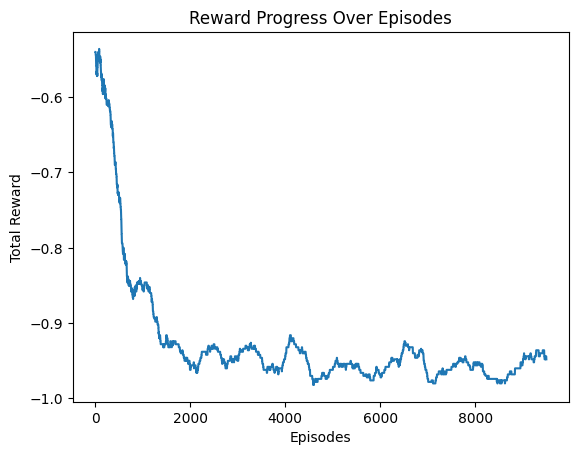

Training Complete, average reward over last 500 episodes: -0.05


In [277]:
plt.plot(moving_average(nstep(), 500))
plt.title('Reward Progress Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')


In [287]:
reset_agent()
seed = 5201

Agent has been reset.


In [288]:
#hyperparameter tuning for all training
params = {
    'batch_size': [128, 256, 512],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'gamma': [0.9, 0.95, 0.99],
    'epsilon_decay': [1000, 5000, 10000],
    'numsteps': [3, 5, 10]
}
n_steps = 500
best_params = None

for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    
                    rewards  = dqnmod(n_steps)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'numsteps': n_steps,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.23
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'numsteps': 500, 'avg_reward': np.float64(-0.23)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 5000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.07
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 5000, 'numsteps': 500, 'avg_reward': np.float64(-0.07000000000000002)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 10000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.22
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.95, epsilon_decay: 1000
Agent has been reset.
Episode 1: 0.01% comple

{'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.95, 'epsilon_decay': 10000, 'numsteps': 500, 'avg_reward': np.float64(0.07999999999999999)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -534.25


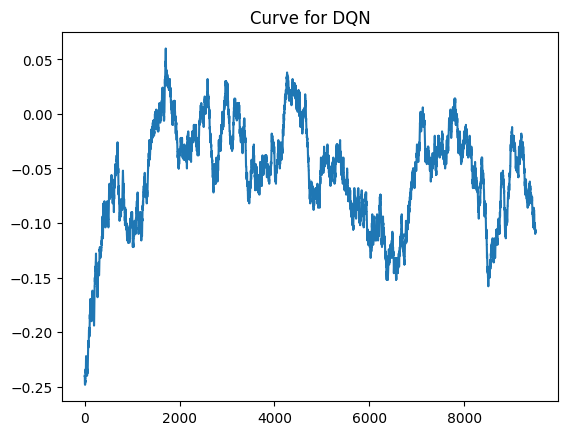

In [289]:
print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = dqnmod(10000)

plt.plot(moving_average(results, 500))
plt.title('Curve for DQN')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

In [290]:
best_params = None

for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    
                    rewards  = doubledqn(n_steps)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'numsteps': n_steps,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.07
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'numsteps': 500, 'avg_reward': np.float64(-0.07000000000000002)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 5000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.22
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 10000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.05
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 10000, 'numsteps': 500, 'avg_reward': np.float64(-0.05000000000000001)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.95, epsilon_decay: 1000
Agent has been reset.
Episode

{'batch_size': 256, 'learning_rate': 0.0001, 'gamma': 0.95, 'epsilon_decay': 1000, 'numsteps': 500, 'avg_reward': np.float64(0.1)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -24895.76


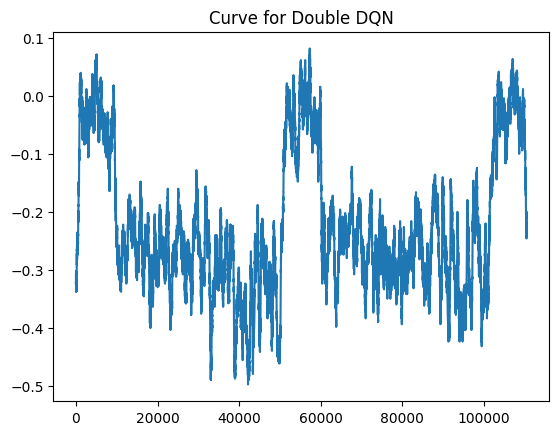

In [291]:
best_params
print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = doubledqn(10000)
plt.plot(moving_average(results, 500))
plt.title('Curve for Double DQN')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

In [292]:
best_params = None
for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                for multis in params['numsteps']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}, n_steps: {multis}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    rewards  = nstep(n_steps,multis)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'DQN steps': multis,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 3
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.55
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN steps': 3, 'avg_reward': np.float64(-0.55)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 5
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.25
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN steps': 5, 'avg_reward': np.float64(-0.25)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 10
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.08
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN

{'batch_size': 256, 'learning_rate': 0.0001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN steps': 3, 'avg_reward': np.float64(0.1)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -8594.52


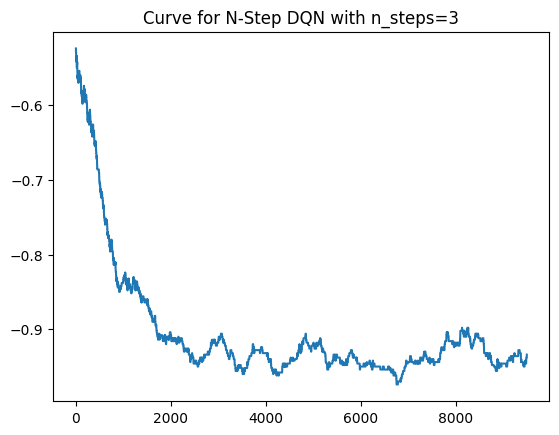

In [293]:

print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = nstep(10000,3)
plt.plot(moving_average(results, 500))
plt.title('Curve for N-Step DQN with n_steps=3')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

# Q3